In [1]:
import os
import numpy as np
import CRNS_library as CRNS_lib
import time
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import CRNS_optimizer as CRNS_opt
from scipy.optimize import curve_fit


def func(x, p1, p2):
    return p1 * np.cos(p2 * x) + p2 * np.sin(p1 * x)
print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 


Not a file to run, only methods included here.

Block completed at time:                       10:42:21 on 2024-09-24


In [2]:

src_path = '.'
##Read in data for one site as example:
#read incoming cosmic ray intensity
file_path=src_path+'/Scaling/JUNG1_Data_UTC.TXT'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Incoming'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Jung = new_data.set_index('DateTime')

##Read in data for one site as example:
#read incoming cosmic ray intensity
file_path=src_path+'/Scaling/OULU_1h_UTC.txt'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Oulu'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Oulu = new_data.set_index('DateTime')


##Read in data for one site as example:
#read incoming cosmic ray intensity
file_path=src_path+'/Scaling/LMKS.txt'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Lmks'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Lmks = new_data.set_index('DateTime')

##Read in data for one site as example:
#read incoming cosmic ray intensity
file_path=src_path+'/Scaling/APTY_1h_UTC.txt'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Apty'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Apty = new_data.set_index('DateTime')



##Read in data for one site as example:
#read incoming cosmic ray intensity
file_path=src_path+'/Scaling/AthensR8.53Alt260 m.txt'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Athens'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Athens = new_data.set_index('DateTime')


##Read in data for one site as example:
#read incoming cosmic ray intensity
file_path=src_path+'/Scaling/MXCO_1h_UTC8.28Alt2274m.txt'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Mxco'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Mxco = new_data.set_index('DateTime')

print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 



Block completed at time:                       10:42:22 on 2024-09-24


In [3]:

## Schäfertal ID 3 removed; and columns renamed; asterisk remarks removed; BUC001 data gaps were removed
fname='EU_Study_sites.csv'
fname="./Scaling/COSMOS_Europe_Data/Additional_information.csv"
site_info = pd.read_csv(fname)
fname="./Scaling/COSMOS_Europe_Data/General_information.csv"
site_general_info = pd.read_csv(fname)
sites_names = site_info.StationID.to_list()
CutoffRigidity = site_info.CutoffRigidity.to_list()
sites_Bulkdensity = site_info.Bulkdensity.to_list()
sites_Altitude = site_general_info.Altitude.to_list()
sites_Precip = site_general_info.Meanannualprecipitation.to_list()
sites_Temperature = site_general_info.Meanairtemperature.to_list()
sites_lat = site_general_info.Latitude.to_list()
dfi = pd.DataFrame({
    'StationID': sites_names,
    'CutoffRigidity': CutoffRigidity,
    'sites_Precip': sites_Precip,
    'sites_Temperature': sites_Temperature,
    'Bulkdensity': sites_Bulkdensity,
    'Altitude': sites_Altitude
})

# Add new columns (beta, omega, psi) with initial values (you can update these later)
dfi['beta'] = np.nan
dfi['beta_sd'] = np.nan
dfi['beta_mae'] = np.nan
dfi['beta_rmse'] = np.nan
dfi['beta_oulu'] = np.nan
dfi['beta_apty'] = np.nan
dfi['beta_lmks'] = np.nan
dfi['beta_mxco'] = np.nan
dfi['beta_athens'] = np.nan
dfi['omega'] = np.nan
dfi['omega_sd'] = np.nan
dfi['omega_oulu'] = np.nan
dfi['omega_apty'] = np.nan
dfi['omega_mxco'] = np.nan
dfi['omega_athens'] = np.nan
dfi['omega_lmks'] = np.nan
dfi['omega_mae'] = np.nan
dfi['omega_rmse'] = np.nan
dfi['psi'] = np.nan
dfi['psi_sd'] = np.nan
dfi['psi_oulu'] = np.nan
dfi['psi_apty'] = np.nan
dfi['psi_athens'] = np.nan
dfi['psi_mxco'] = np.nan
dfi['psi_lmks'] = np.nan
dfi['psi_mae'] = np.nan
dfi['psi_rmse'] = np.nan
dfi['BetaDesilets'] = np.nan
dfi['mean_P'] = np.nan
dfi['mean_N'] = np.nan
dfi['number_of_days_for_regression'] = np.nan
print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 



Block completed at time:                       10:42:22 on 2024-09-24


In [4]:
### Iterate over EU Study sites:
plog_flag_id=0
# Assuming your DataFrame is named 'df'
#df.to_excel('my_dataframe.xlsx', index=False)  # Specify the desired file name
#csv_filename='my_dataframe_slow.csv'

suffix_csv = "rmse_u"
#csv_filename='my_dataframe_moderated_nelder_rmse.csv'
csv_filename=f'my_dataframe_slow_{suffix_csv}-.csv'


if os.path.exists(csv_filename):
    dfi = pd.read_csv(csv_filename, sep=';', index_col=0)  # Set index_col to 0 for row names
    #LOAD DATAFRAME FROM CSV
else:
    #FILL DATA FRAME AND STORE CSV
    for ii,nn in enumerate(sites_names):
        #plog_flag_id=1
        #for ii, nn in enumerate(sites_names[3:5], start=3):
        print("ID:",ii, "Reading:",nn)
        with open("your_file_slow.txt", "a") as file:
            file.write(f'ID: {ii} Site: {nn}\n')
            
        if nn in ['BUC001']:
            continue
        #else:
        print(ii," name: ", nn) #ID, site and fname, same
        DF = CRNS_lib.load_EU_data(src_path+'/Scaling/COSMOS_Europe_Data/',nn)
        DF['Abs_h'] = CRNS_opt.Absolute_conv(DF.RH, DF.TEMP)
        #resample to 1 hour exactly, for merging with 1h inc. radiation
        DF = DF.resample('1H').mean()
        #print(DF.columns)
        if DF['NeutronCount_Slow_Cum1h'].notna().sum() < 50:
            print("Less than 50 or no values found")
            pass
        else:
            print("There are counts for slow_cum1h")
            DF["MOD"] = DF['NeutronCount_Slow_Cum1h']

            #print(DF.tail(3))
            DF = DF.join(Jung)
            DF = DF.join(Apty)
            DF = DF.join(Oulu)
            DF = DF.join(Athens)
            DF = DF.join(Mxco)
            DF = DF.join(Lmks)
            DF.index.name = 'Date'
            
            # Normalizing and masking outliers for each column
            prctl_values = [0.1, 0.1, 0.1, 0.4, 0.1, 0.1]
            columns = ["Incoming", "Apty", "Oulu", "Mxco", "Lmks", "Athens"]
            for idcol, col in enumerate(columns):
                lower = 0+prctl_values[idcol]
                upper=100-prctl_values[idcol]
                lower, upper = np.percentile(DF[col].dropna(), [lower,upper])
                DF[col] = DF[col].mask((DF[col] < lower) | (DF[col] > upper))
                
            #print(DF.head(3))
            #print("")
            #print(DF.tail(3))
            #calculate relative scaling for inc. radiation
            DF["Incoming"] = DF["Incoming"]/np.nanmean(DF["Incoming"])
            DF["Apty"] = DF["Apty"]/np.nanmean(DF["Apty"])
            DF["Oulu"] = DF["Oulu"]/np.nanmean(DF["Oulu"])
            DF["Mxco"] = DF["Mxco"]/np.nanmean(DF["Mxco"])
            DF["Lmks"] = DF["Lmks"]/np.nanmean(DF["Lmks"])
            DF["Athens"] = DF["Athens"]/np.nanmean(DF["Athens"])
            #print(DF.index)
            #print(DF.head(2))
            #print(Absolute_conv(80,25))
            my_pars=CRNS_opt.parameter_estimator(DF['Pressure'],DF["MOD"],DF["Incoming"],DF["Abs_h"],"exp",plot_flag=plog_flag_id,site_name=nn,error_metric=suffix_csv)
            dfi.loc[ii, 'beta'] = my_pars[0]
            dfi.loc[ii, 'omega'] = my_pars[1]
            dfi.loc[ii, 'psi'] = my_pars[2]
            dfi.loc[ii, 'beta_sd'] = my_pars[3]
            dfi.loc[ii, 'omega_sd'] = my_pars[4]
            dfi.loc[ii, 'psi_sd'] = my_pars[5]

            #print(my_pars)
            
            my_pars=CRNS_opt.parameter_estimator(DF['Pressure'],DF["MOD"],DF["Apty"],DF["Abs_h"],"exp",plot_flag=plog_flag_id,site_name=nn,error_metric=suffix_csv)
            dfi.loc[ii, 'beta_apty'] = my_pars[0]
            dfi.loc[ii, 'omega_apty'] = my_pars[1]
            dfi.loc[ii, 'psi_apty'] = my_pars[2]
            dfi.loc[ii, 'mean_N'] = my_pars[8]


            my_pars=CRNS_opt.parameter_estimator(DF['Pressure'],DF["MOD"],DF["Oulu"],DF["Abs_h"],"exp",plot_flag=plog_flag_id,site_name=nn,error_metric=suffix_csv)
            dfi.loc[ii, 'beta_oulu'] = my_pars[0]
            dfi.loc[ii, 'omega_oulu'] = my_pars[1]
            dfi.loc[ii, 'psi_oulu'] = my_pars[2]

            
            my_pars=CRNS_opt.parameter_estimator(DF['Pressure'],DF["MOD"],DF["Mxco"],DF["Abs_h"],"exp",plot_flag=plog_flag_id,site_name=nn,error_metric=suffix_csv)
            dfi.loc[ii, 'beta_mxco'] = my_pars[0]
            dfi.loc[ii, 'omega_mxco'] = my_pars[1]
            dfi.loc[ii, 'psi_mxco'] = my_pars[2]

            my_pars=CRNS_opt.parameter_estimator(DF['Pressure'],DF["MOD"],DF["Lmks"],DF["Abs_h"],"exp",plot_flag=plog_flag_id,site_name=nn,error_metric=suffix_csv)
            dfi.loc[ii, 'beta_lmks'] = my_pars[0]
            dfi.loc[ii, 'omega_lmks'] = my_pars[1]
            dfi.loc[ii, 'psi_lmks'] = my_pars[2]

            my_pars=CRNS_opt.parameter_estimator(DF['Pressure'],DF["MOD"],DF["Athens"],DF["Abs_h"],"exp",plot_flag=plog_flag_id,site_name=nn,error_metric=suffix_csv)
            dfi.loc[ii, 'beta_athens'] = my_pars[0]
            dfi.loc[ii, 'omega_athens'] = my_pars[1]
            dfi.loc[ii, 'psi_athens'] = my_pars[2]
            
            my_pars=CRNS_opt.parameter_estimator(DF['Pressure'],DF["MOD"],DF["Incoming"],DF["Abs_h"],"exp",plot_flag=plog_flag_id,site_name=nn,error_metric="mae")
            dfi.loc[ii, 'beta_mae'] = my_pars[0]
            dfi.loc[ii, 'omega_mae'] = my_pars[1]
            dfi.loc[ii, 'psi_mae'] = my_pars[2]
            
            my_pars=CRNS_opt.parameter_estimator(DF['Pressure'],DF["MOD"],DF["Incoming"],DF["Abs_h"],"exp",plot_flag=plog_flag_id,site_name=nn,error_metric="rmse")
            dfi.loc[ii, 'beta_rmse'] = my_pars[0]
            dfi.loc[ii, 'omega_rmse'] = my_pars[1]
            dfi.loc[ii, 'psi_rmse'] = my_pars[2]
            
            mean_air_pressure_for_desilets = my_pars[6]
            number_of_days_for_regression = my_pars[7]
            
            dfi.loc[ii, 'number_of_days_for_regression'] = number_of_days_for_regression
            dfi.loc[ii, 'mean_N'] = my_pars[8]
            g, x, f_lat, f_bar, F_scale, Desilets_beta_eff, Desilets_beta = CRNS_lib.beta_e(mean_air_pressure_for_desilets,CutoffRigidity[ii],sites_lat[ii])
            
            dfi.loc[ii, 'Desilets_beta_eff'] = Desilets_beta_eff
            dfi.loc[ii, 'Desilets_beta'] = Desilets_beta
            dfi.loc[ii, 'mean_P'] = mean_air_pressure_for_desilets
            

    dfi.to_csv(csv_filename, sep=";",index=True)
print("FINISHED THIS BLOCK")

ID: 0 Reading: AAC001
0  name:  AAC001


/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 1 Reading: ACC001
1  name:  ACC001
Less than 50 or no values found
ID: 2 Reading: AGCK003
2  name:  AGCK003
There are counts for slow_cum1h
ID: 3 Reading: ALC001
3  name:  ALC001


/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 4 Reading: ALC002
4  name:  ALC002
Less than 50 or no values found
ID: 5 Reading: BBC001
5  name:  BBC001
Less than 50 or no values found
ID: 6 Reading: BOC001
6  name:  BOC001
Less than 50 or no values found
ID: 7 Reading: BUC001
ID: 8 Reading: CAC001
8  name:  CAC001
Less than 50 or no values found
ID: 9 Reading: CAC002
9  name:  CAC002
Less than 50 or no values found
ID: 10 Reading: CBC001
10  name:  CBC001
Less than 50 or no values found
ID: 11 Reading: CRC001
11  name:  CRC001
Less than 50 or no values found
ID: 12 Reading: CUC001
12  name:  CUC001
There are counts for slow_cum1h
ID: 13 Reading: DEC001
13  name:  DEC001
There are counts for slow_cum1h
ID: 14 Reading: ELC001
14  name:  ELC001


/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 15 Reading: ESC001
15  name:  ESC001
Less than 50 or no values found
ID: 16 Reading: EUC001
16  name:  EUC001
Less than 50 or no values found
ID: 17 Reading: FEC001
17  name:  FEC001
Less than 50 or no values found
ID: 18 Reading: FIC001
18  name:  FIC001
Less than 50 or no values found
ID: 19 Reading: FSC001
19  name:  FSC001
There are counts for slow_cum1h
ID: 20 Reading: GBC001
20  name:  GBC001
There are counts for slow_cum1h
ID: 21 Reading: GLC001
21  name:  GLC001


/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 22 Reading: GRC001
22  name:  GRC001
Less than 50 or no values found
ID: 23 Reading: GSC001
23  name:  GSC001
Less than 50 or no values found
ID: 24 Reading: HAC001
24  name:  HAC001
Less than 50 or no values found
ID: 25 Reading: HDC001
25  name:  HDC001
There are counts for slow_cum1h
ID: 26 Reading: HGC001
26  name:  HGC001


/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 27 Reading: HHC001
27  name:  HHC001
There are counts for slow_cum1h
ID: 28 Reading: HOC001
28  name:  HOC001
There are counts for slow_cum1h
ID: 29 Reading: JEC001
29  name:  JEC001


/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 30 Reading: LBC001
30  name:  LBC001
Less than 50 or no values found
ID: 31 Reading: LEC001
31  name:  LEC001
Less than 50 or no values found
ID: 32 Reading: LUC001
32  name:  LUC001
Less than 50 or no values found
ID: 33 Reading: MEBCK001
33  name:  MEBCK001
There are counts for slow_cum1h
ID: 34 Reading: NOC001
34  name:  NOC001


/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 35 Reading: OLC001
35  name:  OLC001
Less than 50 or no values found
ID: 36 Reading: PEC001
36  name:  PEC001
Less than 50 or no values found
ID: 37 Reading: RIC001
37  name:  RIC001
There are counts for slow_cum1h
ID: 38 Reading: ROC001
38  name:  ROC001


/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 39 Reading: ROC002
39  name:  ROC002
Less than 50 or no values found
ID: 40 Reading: RUBCDKR001
40  name:  RUBCDKR001
There are counts for slow_cum1h
ID: 41 Reading: RUBCK002
41  name:  RUBCK002


/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 42 Reading: RUBCK003
42  name:  RUBCK003
Less than 50 or no values found
ID: 43 Reading: RUBCK004
43  name:  RUBCK004
Less than 50 or no values found
ID: 44 Reading: RUC004
44  name:  RUC004
Less than 50 or no values found
ID: 45 Reading: RUC005
45  name:  RUC005
Less than 50 or no values found
ID: 46 Reading: RUC006
46  name:  RUC006
Less than 50 or no values found
ID: 47 Reading: RUC007
47  name:  RUC007
Less than 50 or no values found
ID: 48 Reading: RUC008
48  name:  RUC008
Less than 50 or no values found
ID: 49 Reading: SAC001
49  name:  SAC001
Less than 50 or no values found
ID: 50 Reading: SCC001
50  name:  SCC001
Less than 50 or no values found
ID: 51 Reading: SCC004
51  name:  SCC004
Less than 50 or no values found
ID: 52 Reading: SEC001
52  name:  SEC001
Less than 50 or no values found
ID: 53 Reading: SHC001
53  name:  SHC001
Less than 50 or no values found
ID: 54 Reading: SHC002
54  name:  SHC002
Less than 50 or no values found
ID: 55 Read

/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 58 Reading: WAC001
58  name:  WAC001
There are counts for slow_cum1h
ID: 59 Reading: WEC001
59  name:  WEC001


/beegfs/baatz/jupyter_playgroundpython3.10_2.0/.conda/envs/jupyterenv/lib/python3.10/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Less than 50 or no values found
ID: 60 Reading: WUC001
60  name:  WUC001
Less than 50 or no values found
ID: 61 Reading: WUC002
61  name:  WUC002
Less than 50 or no values found
ID: 62 Reading: WUC003
62  name:  WUC003
Less than 50 or no values found
ID: 63 Reading: ZEC001
63  name:  ZEC001
Less than 50 or no values found
ID: 64 Reading: ZUC001
64  name:  ZUC001
Less than 50 or no values found
FINISHED THIS BLOCK


In [5]:
# Assuming your DataFrame is named 'df'
#df.to_excel('my_dataframe.xlsx', index=False)  # Specify the desired file name
#csv_filename='my_dataframe_slow.csv'
#dfi.to_csv(csv_filename, sep=";",index=False)
#csv_filename='my_dataframe_slow.csv.xlsx'
#dfi.to_csv(csv_filename, sep=";",index=False)
# Read the CSV file into a DataFrame


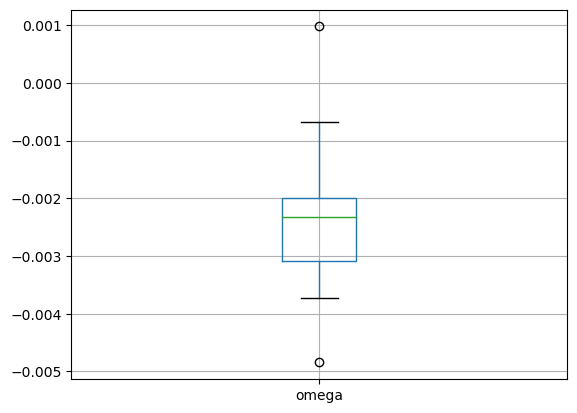

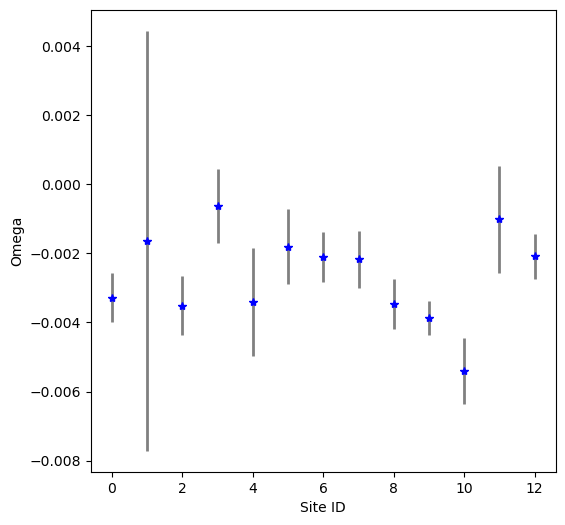

Save file as ./omega_all1_slow.png


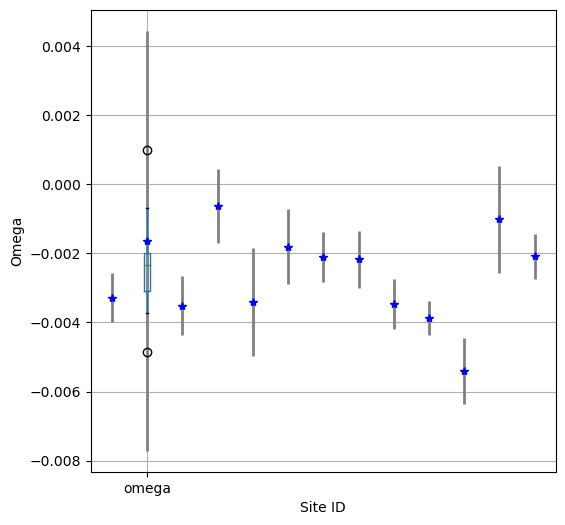

Save file as ./omega_all1_box_slow_slow.png


In [6]:
dfi.dropna(subset=['psi'], inplace=True)

df=dfi.copy()

#df.drop(index=31, inplace=True)
# Assuming your DataFrame is named 'df'
df.boxplot(column='omega')
# If you want to create a single boxplot for all columns, use:
# df.plot(kind='box')
plt.show()

fig = plt.figure(figsize=(6, 6))
for ii in range(len(df)):
    plt.errorbar(ii, df['omega_mae'].iloc[ii], yerr=df['omega_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)
plt.xlabel('Site ID')
plt.ylabel('Omega')
plt.show()
pngname="./omega_all1_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')



fig = plt.figure(figsize=(6, 6))
for ii in range(len(df)):
    plt.errorbar(ii, df['omega_mae'].iloc[ii], yerr=df['omega_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)
df.boxplot(column='omega')
plt.xlabel('Site ID')
plt.ylabel('Omega')
plt.show()

pngname="./omega_all1_box_slow_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')


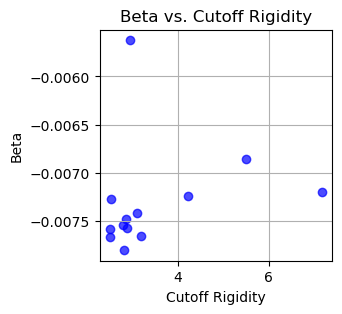

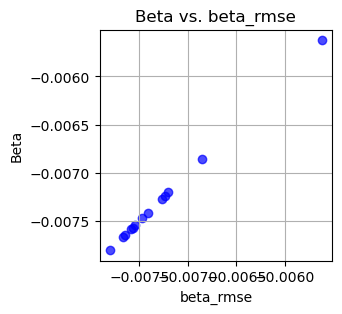

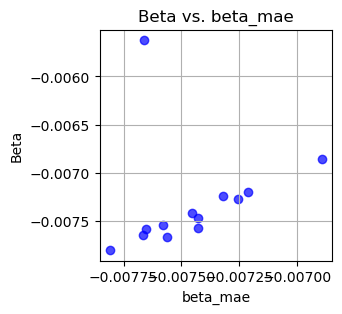

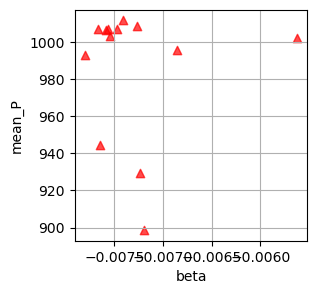

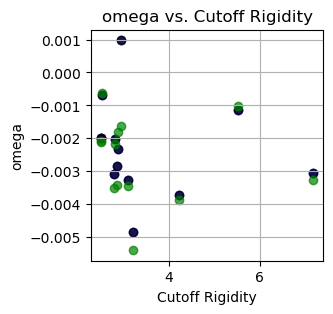

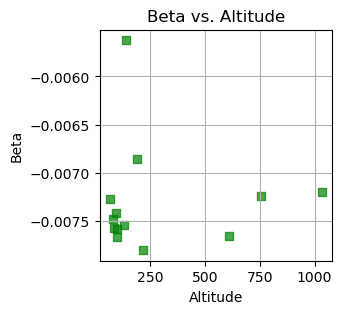

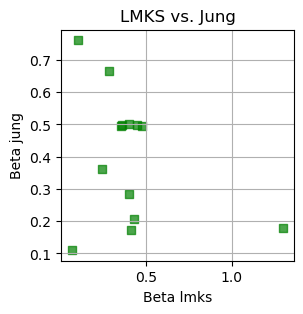

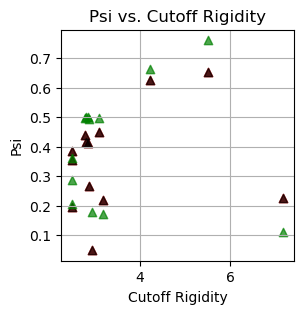

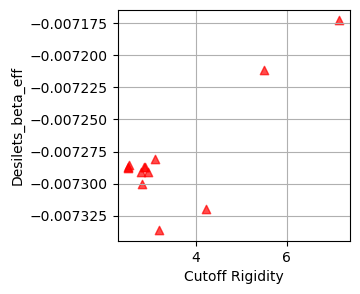

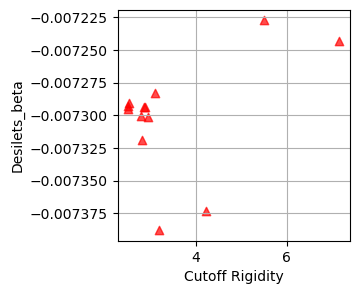

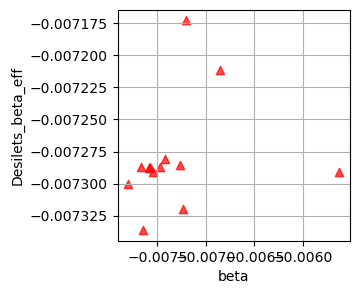

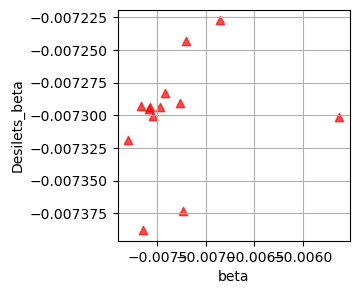

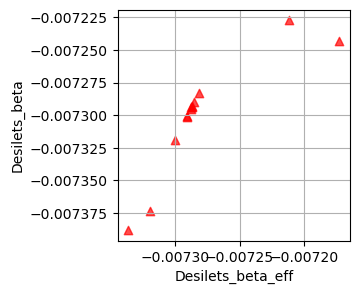

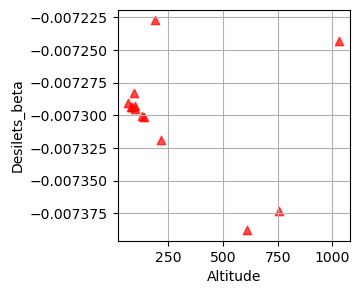

In [7]:
df=dfi.copy()
# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['beta'], color='b', marker='o', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('Beta')
plt.title('Beta vs. Cutoff Rigidity')
plt.grid(True)
plt.show()

# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['beta_rmse'], df['beta'], color='b', marker='o', alpha=0.7)
plt.xlabel('beta_rmse')
plt.ylabel('Beta')
plt.title('Beta vs. beta_rmse')
plt.grid(True)
plt.show()

# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['beta_mae'], df['beta'], color='b', marker='o', alpha=0.7)
plt.xlabel('beta_mae')
plt.ylabel('Beta')
plt.title('Beta vs. beta_mae')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3))
plt.scatter(df['beta'], df['mean_P'], color='r', marker='^', alpha=0.7)
plt.xlabel('beta')
plt.ylabel('mean_P')
plt.grid(True)
plt.show()

# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['omega'], color='b', marker='o', alpha=0.7)
plt.scatter(df['CutoffRigidity'], df['omega_rmse'], color='k', marker='o', alpha=0.7)
plt.scatter(df['CutoffRigidity'], df['omega_mae'], color='g', marker='o', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('omega')
plt.title('omega vs. Cutoff Rigidity')
plt.grid(True)
plt.show()

# Scatterplot: Beta vs. Altitude
plt.figure(figsize=(3, 3))
plt.scatter(df['Altitude'], df['beta'], color='g', marker='s', alpha=0.7)
plt.xlabel('Altitude')
plt.ylabel('Beta')
plt.title('Beta vs. Altitude')
plt.grid(True)
plt.show()

# Scatterplot: Beta vs. Altitude
plt.figure(figsize=(3, 3))
plt.scatter(df['psi_lmks'], df['psi_mae'], color='g', marker='s', alpha=0.7)
plt.xlabel('Beta lmks')
plt.ylabel('Beta jung')
plt.title('LMKS vs. Jung')
plt.grid(True)
plt.show()

# Scatterplot: Psi vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['psi'], color='r', marker='^', alpha=0.7)
plt.scatter(df['CutoffRigidity'], df['psi_rmse'], color='k', marker='^', alpha=0.7)
plt.scatter(df['CutoffRigidity'], df['psi_mae'], color='g', marker='^', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('Psi')
plt.title('Psi vs. Cutoff Rigidity')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['Desilets_beta_eff'], color='r', marker='^', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('Desilets_beta_eff')
plt.grid(True)
plt.show()


plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['Desilets_beta'], color='r', marker='^', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('Desilets_beta')
plt.grid(True)
plt.show()


plt.figure(figsize=(3, 3))
plt.scatter(df['beta'], df['Desilets_beta_eff'], color='r', marker='^', alpha=0.7)
plt.xlabel('beta')
plt.ylabel('Desilets_beta_eff')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3))
plt.scatter(df['beta'], df['Desilets_beta'], color='r', marker='^', alpha=0.7)
plt.xlabel('beta')    
plt.ylabel('Desilets_beta')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3))
plt.scatter(df['Desilets_beta_eff'], df['Desilets_beta'], color='r', marker='^', alpha=0.7)
plt.xlabel('Desilets_beta_eff')
plt.ylabel('Desilets_beta')
plt.grid(True)
plt.show()


plt.figure(figsize=(3, 3))
plt.scatter(df['Altitude'], df['Desilets_beta'], color='r', marker='^', alpha=0.7)
plt.xlabel('Altitude')
plt.ylabel('Desilets_beta')
plt.grid(True)
plt.show()




     StationID  CutoffRigidity  sites_Precip  sites_Temperature  Bulkdensity  \
2      AGCK003            7.17          1003               12.5        1.258   
12      CUC001            2.94           868               10.5        1.491   
13      DEC001            2.79           550                7.5        1.430   
19      FSC001            2.51           580                9.7        1.135   
20      GBC001            2.85           845                9.9        1.176   
25      HDC001            2.87           818               10.0        1.278   
27      HHC001            2.50           580                9.7        1.014   
28      HOC001            2.81           820               10.0        1.136   
33    MEBCK001            3.09           718               10.3        1.310   
37      RIC001            4.22          1460                7.1        0.964   
40  RUBCDKR001            3.19           870                7.0        1.000   
56      TOC001            5.51          

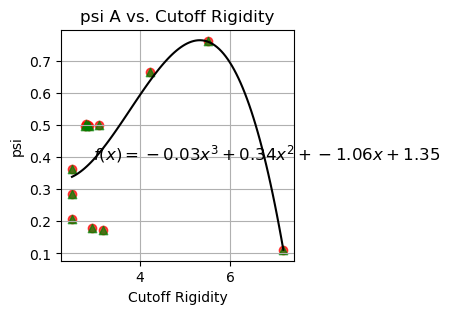

In [8]:
df = dfi.copy()
print(dfi)
# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['psi_mae'], color='r', marker='o', alpha=0.7)
xdata = df['CutoffRigidity']
ydata = df['psi_mae']

popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))

coefficients = np.polyfit(xdata, ydata, 3)

# Create a polynomial function
p = np.poly1d(coefficients)

# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)

curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='g', marker='^', alpha=0.7)
plt.plot(xaxis, curve_y, color='black', label='Fitted Line')
uncertainty = np.sqrt(np.diag(pcov))
#plt.fill_between(xaxis, curve_y - uncertainty, curve_y + uncertainty, color='grey', alpha=0.3)
#plt.text(xaxis[10], curve_y[10], f'$f(x) = {popt[0]:.2f} \\cos({popt[1]:.2f}x) + {popt[1]:.2f} \\sin({popt[0]:.2f}x)$', fontsize=12)
# Display the function as text on the plot
#plt.text(xaxis[10], curve_y[10], f'$f(x) = {coefficients[0]:.2f} \\cos({coefficients[1]:.2f}x) + {coefficients[1]:.2f} \\sin({coefficients[0]:.2f}x)$', fontsize=12)

function_text = f'$f(x) = {coefficients[0]:.2f}x^3 + {coefficients[1]:.2f}x^2 + {coefficients[2]:.2f}x + {coefficients[3]:.2f}$'
plt.text(xaxis[10], curve_y[10], function_text, fontsize=12)

plt.xlabel('Cutoff Rigidity')
plt.ylabel('psi')
plt.title('psi A vs. Cutoff Rigidity')
plt.grid(True)
plt.show()


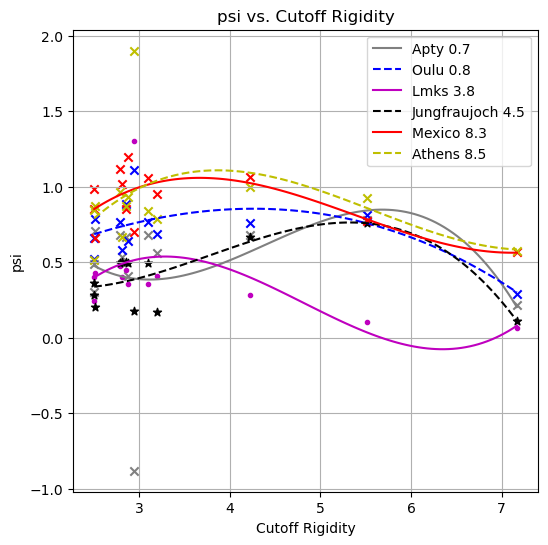

Save file as ./psi_all_by_cutoff_rigidityC_slow.png


<Figure size 640x480 with 0 Axes>

In [9]:
df = dfi.copy()
from scipy.optimize import curve_fit
def func(x, p1, p2):
    return p1 * np.cos(p2 * x) + p2 * np.sin(p1 * x)

# Scatterplot: Beta vs. Cutoff Rigidity
fig = plt.figure(figsize=(6, 6))
xdata = df['CutoffRigidity']


ydata = df['psi_apty']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='grey', marker='x')
plt.plot(xaxis, curve_y, color='grey', label='Apty 0.7')


ydata = df['psi_oulu']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='blue', marker='x')
plt.plot(xaxis, curve_y, color='blue', label='Oulu 0.8', linestyle='--')

ydata = df['psi_lmks']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='m', marker='.')
plt.plot(xaxis, curve_y, color='m', label='Lmks 3.8')


ydata = df['psi_mae']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='black', marker='*')
plt.plot(xaxis, curve_y, color='black', label='Jungfraujoch 4.5', linestyle='--')

ydata = df['psi_mxco']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='red', marker='x')
plt.plot(xaxis, curve_y, color='red', label='Mexico 8.3')



ydata = df['psi_athens']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='y', marker='x')
plt.plot(xaxis, curve_y, color='y', label='Athens 8.5', linestyle='--')



plt.xlabel('Cutoff Rigidity')
plt.ylabel('psi')
plt.title('psi vs. Cutoff Rigidity')
plt.grid(True)
plt.legend()
plt.show()


# Adjust layout to not overlap plots
plt.tight_layout()


pngname="./psi_all_by_cutoff_rigidityC_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')


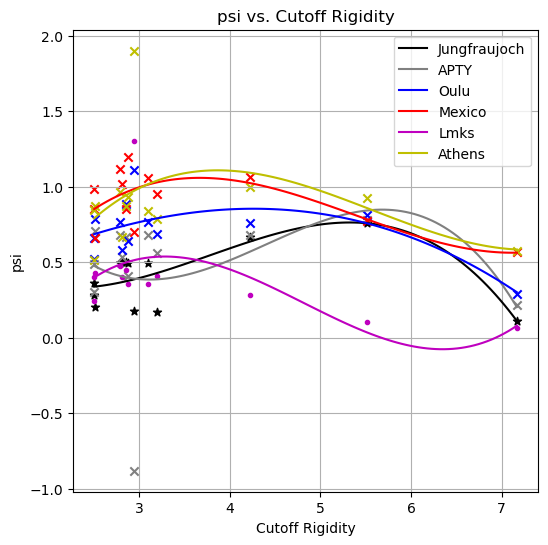

Save file as ./psi_all_by_cutoff_rigidityB_slow.png


<Figure size 640x480 with 0 Axes>

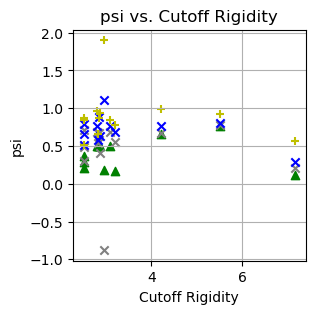

Save file as ./psi_mae_cutoff_rigidityA_slow.png


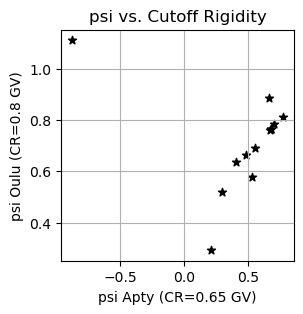

Save file as ./psi_apty_oulu_slow.png


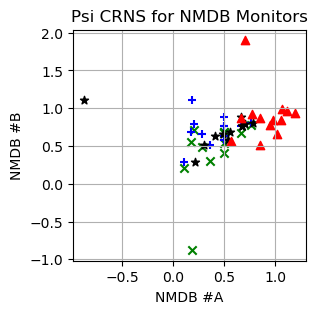

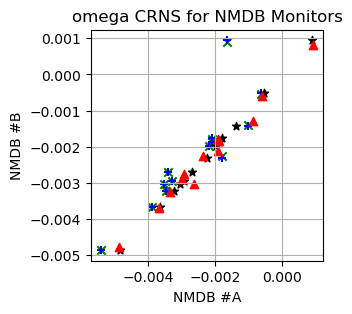

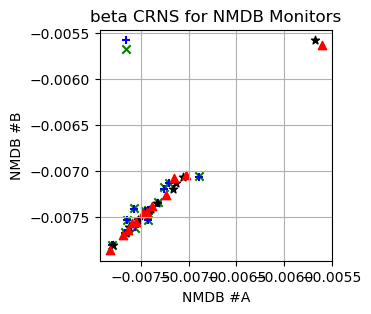

In [10]:
df = dfi.copy()
from scipy.optimize import curve_fit
def func(x, p1, p2):
    return p1 * np.cos(p2 * x) + p2 * np.sin(p1 * x)

# Scatterplot: Beta vs. Cutoff Rigidity
fig = plt.figure(figsize=(6, 6))
xdata = df['CutoffRigidity']
ydata = df['psi_mae']

popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))

coefficients = np.polyfit(xdata, ydata, 3)

# Create a polynomial function
p = np.poly1d(coefficients)

# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)

curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='black', marker='*')
plt.plot(xaxis, curve_y, color='black', label='Jungfraujoch')
uncertainty = np.sqrt(np.diag(pcov))
#plt.fill_between(xaxis, curve_y - uncertainty, curve_y + uncertainty, color='grey', alpha=0.3)
#plt.text(xaxis[10], curve_y[10], f'$f(x) = {popt[0]:.2f} \\cos({popt[1]:.2f}x) + {popt[1]:.2f} \\sin({popt[0]:.2f}x)$', fontsize=12)
# Display the function as text on the plot
#plt.text(xaxis[10], curve_y[10], f'$f(x) = {coefficients[0]:.2f} \\cos({coefficients[1]:.2f}x) + {coefficients[1]:.2f} \\sin({coefficients[0]:.2f}x)$', fontsize=12)

function_text = f'$f(x) = {coefficients[0]:.2f}x^3 + {coefficients[1]:.2f}x^2 + {coefficients[2]:.2f}x + {coefficients[3]:.2f}$'
#plt.text(xaxis[10], curve_y[10], function_text, fontsize=12)


ydata = df['psi_apty']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='grey', marker='x')
plt.plot(xaxis, curve_y, color='grey', label='APTY')


ydata = df['psi_oulu']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='blue', marker='x')
plt.plot(xaxis, curve_y, color='blue', label='Oulu')




ydata = df['psi_mxco']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='red', marker='x')
plt.plot(xaxis, curve_y, color='red', label='Mexico')



ydata = df['psi_lmks']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='m', marker='.')
plt.plot(xaxis, curve_y, color='m', label='Lmks')



ydata = df['psi_athens']
popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))
coefficients = np.polyfit(xdata, ydata, 3)
# Create a polynomial function
p = np.poly1d(coefficients)
# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)
curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='y', marker='x')
plt.plot(xaxis, curve_y, color='y', label='Athens')

plt.xlabel('Cutoff Rigidity')
plt.ylabel('psi')
plt.title('psi vs. Cutoff Rigidity')
plt.grid(True)
plt.legend()
plt.show()


# Adjust layout to not overlap plots
plt.tight_layout()


pngname="./psi_all_by_cutoff_rigidityB_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')




# Scatterplot: Beta vs. Cutoff Rigidity
fig=plt.figure(figsize=(3, 3))
xdata = df['CutoffRigidity']
ydata = df['psi_mae']
plt.scatter(xdata, ydata, color='g', marker='^', label='Jung1')

ydata = df['psi_apty']
plt.scatter(xdata, ydata, color='grey', marker='x',label='APTY')

ydata = df['psi_oulu']
plt.scatter(xdata, ydata, color='blue', marker='x', label='OULU')

#ydata = df['psi_mxco']
#plt.scatter(xdata, ydata, color='r', marker='+', label='Mxco')

ydata = df['psi_athens']
plt.scatter(xdata, ydata, color='y', marker='+', label='Athens')

plt.xlabel('Cutoff Rigidity')
plt.ylabel('psi')
plt.title('psi vs. Cutoff Rigidity')
plt.grid(True)
plt.show()

pngname="./psi_mae_cutoff_rigidityA_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')






# Scatterplot: Beta vs. Cutoff Rigidity
fig=plt.figure(figsize=(3, 3))

plt.scatter(df['psi_apty'],  df['psi_oulu'], color='k', marker='*', label='Apty vs Oulu')

plt.xlabel('psi Apty (CR=0.65 GV)')
plt.ylabel('psi Oulu (CR=0.8 GV)')
plt.title('psi vs. Cutoff Rigidity')
plt.grid(True)
plt.show()

pngname="./psi_apty_oulu_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')


# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['psi_mae'],  df['psi_apty'], color='g', marker='x', label='Jung vs Apty')
plt.scatter(df['psi_mae'],  df['psi_oulu'], color='b', marker='+', label='Jung vs Oulu')
plt.scatter(df['psi_apty'],  df['psi_oulu'], color='k', marker='*', label='Apty vs Oulu')
plt.scatter(df['psi_mxco'],  df['psi_athens'], color='r', marker='^', label='Mxco vs Athens')

plt.xlabel('NMDB #A')
plt.ylabel('NMDB #B')
plt.title('Psi CRNS for NMDB Monitors')
plt.grid(True)
plt.show()




# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['omega_mae'],  df['omega_apty'], color='g', marker='x', label='Jung vs Apty')
plt.scatter(df['omega_mae'],  df['omega_oulu'], color='b', marker='+', label='Jung vs Oulu')
plt.scatter(df['omega_apty'],  df['omega_oulu'], color='k', marker='*', label='Apty vs Oulu')
plt.scatter(df['omega_mxco'],  df['omega_athens'], color='r', marker='^', label='Mxco vs Athens')

plt.xlabel('NMDB #A')
plt.ylabel('NMDB #B')
plt.title('omega CRNS for NMDB Monitors')
plt.grid(True)
plt.show()




# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['beta_mae'],  df['beta_apty'], color='g', marker='x', label='Jung vs Apty')
plt.scatter(df['beta_mae'],  df['beta_oulu'], color='b', marker='+', label='Jung vs Oulu')
plt.scatter(df['beta_apty'],  df['beta_oulu'], color='k', marker='*', label='Apty vs Oulu')
plt.scatter(df['beta_mxco'],  df['beta_athens'], color='r', marker='^', label='Mxco vs Athens')

plt.xlabel('NMDB #A')
plt.ylabel('NMDB #B')
plt.title('beta CRNS for NMDB Monitors')
plt.grid(True)
plt.show()


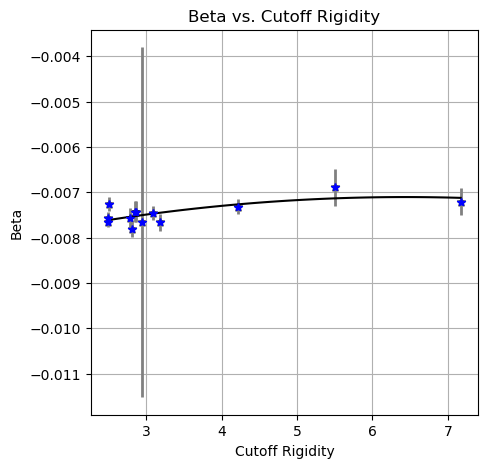

Save file as ./beta_mae_cutoff_rigidity_slow.png


In [11]:
df=dfi.copy()
#df.drop(index=31, inplace=True)
#ID: 31 Reading: LEC001
# Scatterplot: Beta vs. Cutoff Rigidity
fig=plt.figure(figsize=(5, 5))
for ii in range(len(df)):
    plt.errorbar(df['CutoffRigidity'].iloc[ii], df['beta_mae'].iloc[ii], yerr=df['beta_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)

plt.scatter(df['CutoffRigidity'], df['beta_mae'], color='k', marker='.', alpha=0.7)



xdata = df['CutoffRigidity']
ydata = df['beta_mae']

popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))

coefficients = np.polyfit(xdata, ydata, 2)

# Create a polynomial function
p = np.poly1d(coefficients)

# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)

curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='black', marker='*')
plt.plot(xaxis, curve_y, color='black', label='Fitted Line')


plt.xlabel('Cutoff Rigidity')
plt.ylabel('Beta')
plt.title('Beta vs. Cutoff Rigidity')
plt.grid(True)
plt.show()


pngname="./beta_mae_cutoff_rigidity_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')




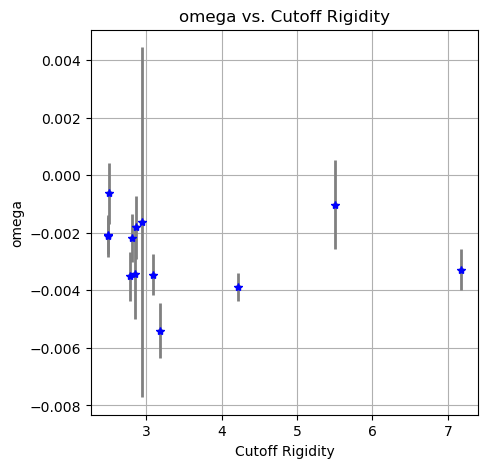

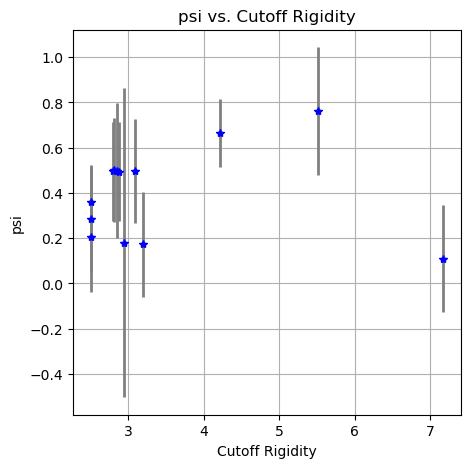

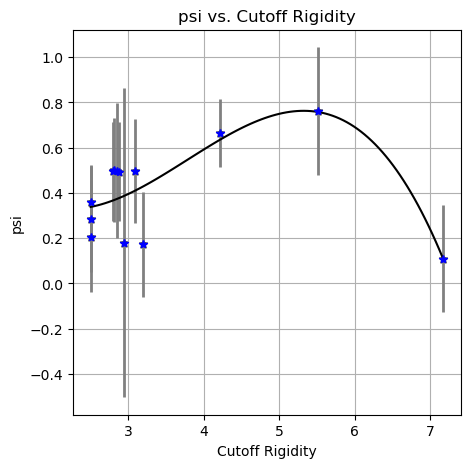

Save file as ./psi_mae_cutoff_rigidity_slow.png


In [12]:
df=dfi.copy()
#df.drop(index=31, inplace=True)
#ID: 31 Reading: LEC001
# Scatterplot: Beta vs. Cutoff Rigidity



plt.figure(figsize=(5, 5))
for ii in range(len(df)):
    plt.errorbar(df['CutoffRigidity'].iloc[ii], df['omega_mae'].iloc[ii], yerr=df['omega_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)

plt.scatter(df['CutoffRigidity'], df['omega_mae'], color='k', marker='.', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('omega')
plt.title('omega vs. Cutoff Rigidity')
plt.grid(True)
plt.show()


plt.figure(figsize=(5, 5))
for ii in range(len(df)):
    plt.errorbar(df['CutoffRigidity'].iloc[ii], df['psi_mae'].iloc[ii], yerr=df['psi_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)

plt.scatter(df['CutoffRigidity'], df['psi_mae'], color='k', marker='.', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('psi')
plt.title('psi vs. Cutoff Rigidity')
plt.grid(True)
plt.show()
##repeat for psi and omega



fig=plt.figure(figsize=(5, 5))

for ii in range(len(df)):
    plt.errorbar(df['CutoffRigidity'].iloc[ii], df['psi_mae'].iloc[ii], yerr=df['psi_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)

plt.scatter(df['CutoffRigidity'], df['psi_mae'], color='k', marker='.', alpha=0.7)

xdata = df['CutoffRigidity']
ydata = df['psi_mae']

popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))

coefficients = np.polyfit(xdata, ydata, 3)

# Create a polynomial function
p = np.poly1d(coefficients)

# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)

curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='black', marker='*')
plt.plot(xaxis, curve_y, color='black', label='Fitted Line')
uncertainty = np.sqrt(np.diag(pcov))
#plt.fill_between(xaxis, curve_y - uncertainty, curve_y + uncertainty, color='grey', alpha=0.3)
#plt.text(xaxis[10], curve_y[10], f'$f(x) = {popt[0]:.2f} \\cos({popt[1]:.2f}x) + {popt[1]:.2f} \\sin({popt[0]:.2f}x)$', fontsize=12)
# Display the function as text on the plot
#plt.text(xaxis[10], curve_y[10], f'$f(x) = {coefficients[0]:.2f} \\cos({coefficients[1]:.2f}x) + {coefficients[1]:.2f} \\sin({coefficients[0]:.2f}x)$', fontsize=12)

function_text = f'$f(x) = {coefficients[0]:.2f}x^3 + {coefficients[1]:.2f}x^2 + {coefficients[2]:.2f}x + {coefficients[3]:.2f}$'


plt.xlabel('Cutoff Rigidity')
plt.ylabel('psi')
plt.title('psi vs. Cutoff Rigidity')
plt.grid(True)
plt.show()


pngname="./psi_mae_cutoff_rigidity_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')


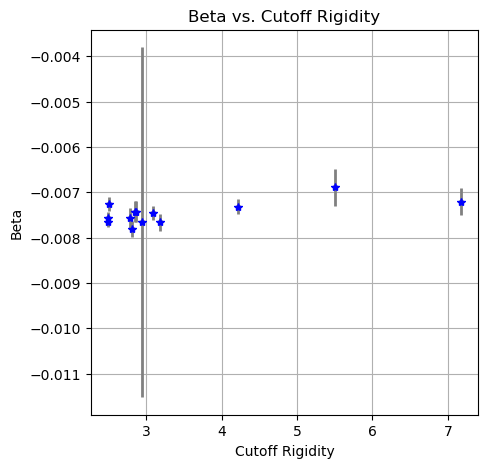

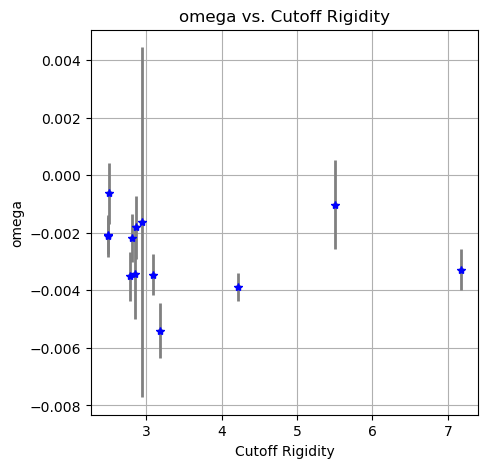

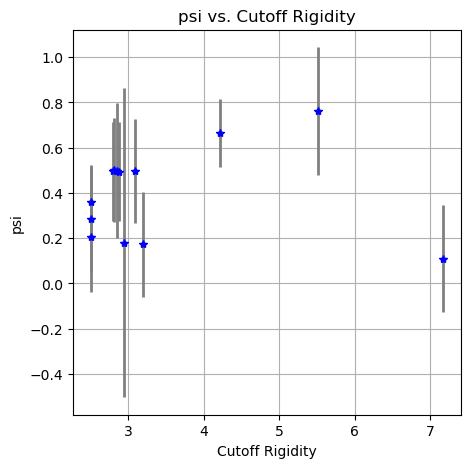

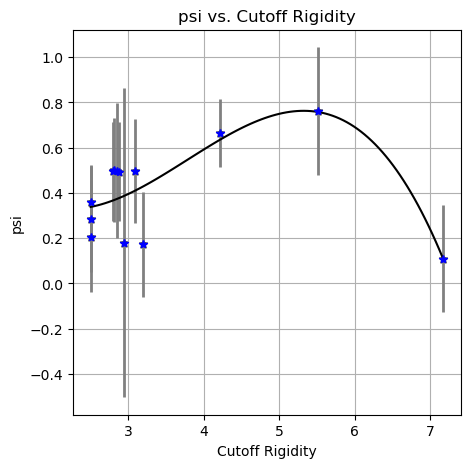

In [13]:
df=dfi.copy()
#df.drop(index=31, inplace=True)
#ID: 31 Reading: LEC001
# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(5, 5))
for ii in range(len(df)):
    plt.errorbar(df['CutoffRigidity'].iloc[ii], df['beta_mae'].iloc[ii], yerr=df['beta_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)

plt.scatter(df['CutoffRigidity'], df['beta_mae'], color='k', marker='.', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('Beta')
plt.title('Beta vs. Cutoff Rigidity')
plt.grid(True)
plt.show()


plt.figure(figsize=(5, 5))
for ii in range(len(df)):
    plt.errorbar(df['CutoffRigidity'].iloc[ii], df['omega_mae'].iloc[ii], yerr=df['omega_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)

plt.scatter(df['CutoffRigidity'], df['omega_mae'], color='k', marker='.', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('omega')
plt.title('omega vs. Cutoff Rigidity')
plt.grid(True)
plt.show()


plt.figure(figsize=(5, 5))
for ii in range(len(df)):
    plt.errorbar(df['CutoffRigidity'].iloc[ii], df['psi_mae'].iloc[ii], yerr=df['psi_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)

plt.scatter(df['CutoffRigidity'], df['psi_mae'], color='k', marker='.', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('psi')
plt.title('psi vs. Cutoff Rigidity')
plt.grid(True)
plt.show()
##repeat for psi and omega



plt.figure(figsize=(5, 5))

for ii in range(len(df)):
    plt.errorbar(df['CutoffRigidity'].iloc[ii], df['psi_mae'].iloc[ii], yerr=df['psi_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)

plt.scatter(df['CutoffRigidity'], df['psi_mae'], color='k', marker='.', alpha=0.7)

xdata = df['CutoffRigidity']
ydata = df['psi_mae']

popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))

coefficients = np.polyfit(xdata, ydata, 3)

# Create a polynomial function
p = np.poly1d(coefficients)

# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)

curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='black', marker='*')
plt.plot(xaxis, curve_y, color='black', label='Fitted Line')
uncertainty = np.sqrt(np.diag(pcov))
#plt.fill_between(xaxis, curve_y - uncertainty, curve_y + uncertainty, color='grey', alpha=0.3)
#plt.text(xaxis[10], curve_y[10], f'$f(x) = {popt[0]:.2f} \\cos({popt[1]:.2f}x) + {popt[1]:.2f} \\sin({popt[0]:.2f}x)$', fontsize=12)
# Display the function as text on the plot
#plt.text(xaxis[10], curve_y[10], f'$f(x) = {coefficients[0]:.2f} \\cos({coefficients[1]:.2f}x) + {coefficients[1]:.2f} \\sin({coefficients[0]:.2f}x)$', fontsize=12)

function_text = f'$f(x) = {coefficients[0]:.2f}x^3 + {coefficients[1]:.2f}x^2 + {coefficients[2]:.2f}x + {coefficients[3]:.2f}$'


plt.xlabel('Cutoff Rigidity')
plt.ylabel('psi')
plt.title('psi vs. Cutoff Rigidity')
plt.grid(True)
plt.show()

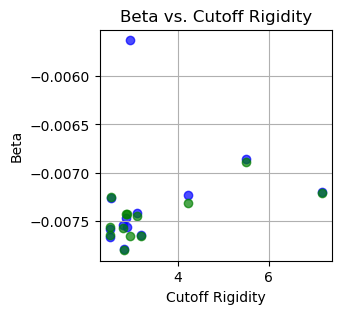

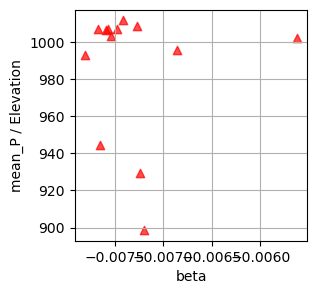

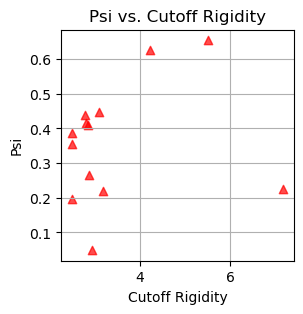

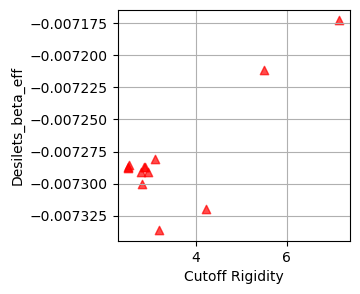

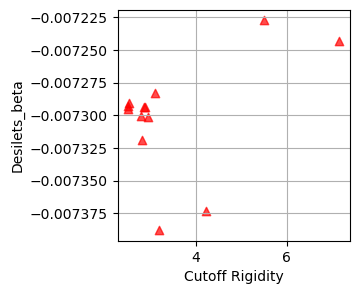

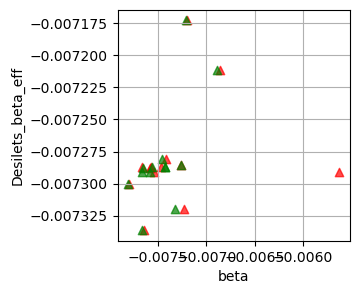

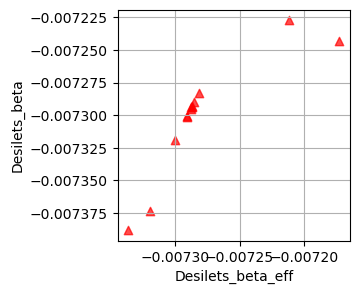

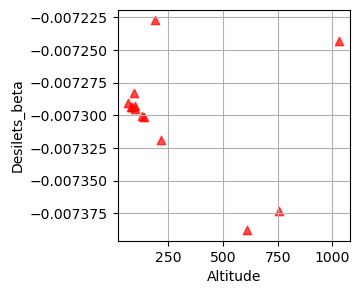

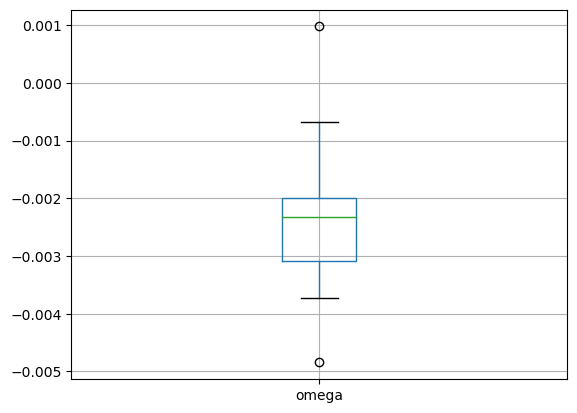

In [14]:

df=dfi.copy()
#df.drop(index=31, inplace=True) #ID: 31 Reading: LEC001

# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['beta'], color='b', marker='o', alpha=0.7)
plt.scatter(df['CutoffRigidity'], df['beta_mae'], color='g', marker='o', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('Beta')
plt.title('Beta vs. Cutoff Rigidity')
plt.grid(True)
plt.show()
"""
# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['beta_rmse'], df['beta'], color='b', marker='o', alpha=0.7)
plt.xlabel('beta_rmse')
plt.ylabel('Beta')
plt.title('Beta vs. beta_rmse')
plt.grid(True)
plt.show()
"""
"""
# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['beta_mae'], df['beta'], color='b', marker='o', alpha=0.7)
plt.xlabel('beta_mae')
plt.ylabel('Beta')
plt.title('Beta vs. beta_mae')
plt.grid(True)
plt.show()
"""
plt.figure(figsize=(3, 3))
plt.scatter(df['beta'], df['mean_P'], color='r', marker='^', alpha=0.7)
plt.xlabel('beta')
plt.ylabel('mean_P / Elevation')
plt.grid(True)
plt.show()

"""
# Scatterplot: Beta vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['omega'], color='b', marker='o', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('omega')
plt.title('omega vs. Cutoff Rigidity')
plt.grid(True)
plt.show()
"""

"""
# Scatterplot: Beta vs. Altitude
plt.figure(figsize=(3, 3))
plt.scatter(df['Altitude'], df['beta'], color='g', marker='s', alpha=0.7)
plt.xlabel('Altitude')
plt.ylabel('Beta')
plt.title('Beta vs. Altitude')
plt.grid(True)
plt.show()
"""

# Scatterplot: Psi vs. Cutoff Rigidity
plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['psi'], color='r', marker='^', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('Psi')
plt.title('Psi vs. Cutoff Rigidity')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['Desilets_beta_eff'], color='r', marker='^', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('Desilets_beta_eff')
plt.grid(True)
plt.show()


plt.figure(figsize=(3, 3))
plt.scatter(df['CutoffRigidity'], df['Desilets_beta'], color='r', marker='^', alpha=0.7)
plt.xlabel('Cutoff Rigidity')
plt.ylabel('Desilets_beta')
plt.grid(True)
plt.show()


plt.figure(figsize=(3, 3))
plt.scatter(df['beta'], df['Desilets_beta_eff'], color='r', marker='^', alpha=0.7)
plt.scatter(df['beta_mae'], df['Desilets_beta_eff'], color='g', marker='^', alpha=0.7)
plt.xlabel('beta')
plt.ylabel('Desilets_beta_eff')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3))
plt.scatter(df['Desilets_beta_eff'], df['Desilets_beta'], color='r', marker='^', alpha=0.7)
plt.xlabel('Desilets_beta_eff')
plt.ylabel('Desilets_beta')
plt.grid(True)
plt.show()


plt.figure(figsize=(3, 3))
plt.scatter(df['Altitude'], df['Desilets_beta'], color='r', marker='^', alpha=0.7)
plt.xlabel('Altitude')
plt.ylabel('Desilets_beta')
plt.grid(True)
plt.show()

# Assuming your DataFrame is named 'df'
df.boxplot(column='omega')
# If you want to create a single boxplot for all columns, use:
# df.plot(kind='box')
plt.show()


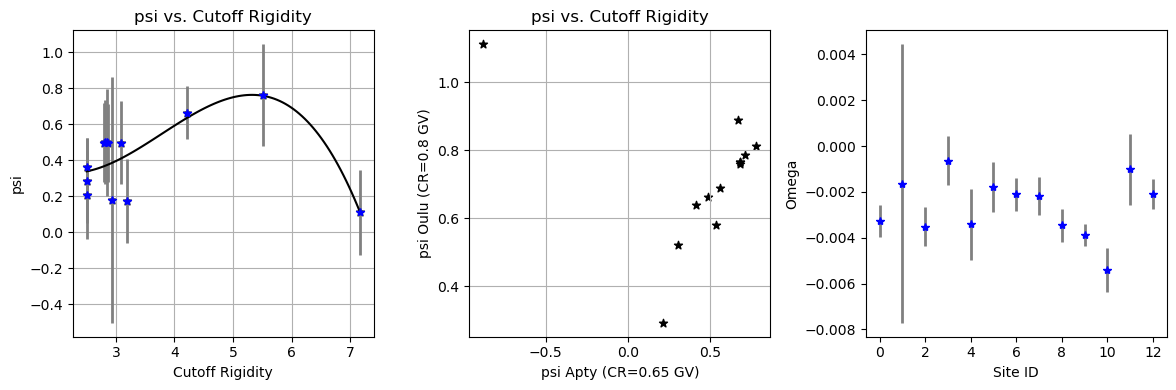

Save file as ./3-subplots-psi-omega_slow.png


In [15]:
df=dfi.copy()
#df.drop(index=31, inplace=True) #ID: 31 Reading: LEC001

# Initialize subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plt.subplot(1, 3, 1) 

for ii in range(len(df)):
    plt.errorbar(df['CutoffRigidity'].iloc[ii], df['psi_mae'].iloc[ii], yerr=df['psi_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)

plt.scatter(df['CutoffRigidity'], df['psi_mae'], color='k', marker='.', alpha=0.7)

xdata = df['CutoffRigidity']
ydata = df['psi_mae']

popt, pcov = curve_fit(func, xdata, ydata, p0=(1.0, 0.3))

coefficients = np.polyfit(xdata, ydata, 3)

# Create a polynomial function
p = np.poly1d(coefficients)

# Now you can use 'p' to evaluate the polynomial at any point 'x':
xaxis = np.linspace(min(xdata), max(xdata), 100)
curve_y = func(xaxis, *popt)

curve_y = p(xaxis)
plt.scatter(xdata, ydata, color='black', marker='*')
plt.plot(xaxis, curve_y, color='black', label='Fitted Line')
uncertainty = np.sqrt(np.diag(pcov))
#plt.fill_between(xaxis, curve_y - uncertainty, curve_y + uncertainty, color='grey', alpha=0.3)
#plt.text(xaxis[10], curve_y[10], f'$f(x) = {popt[0]:.2f} \\cos({popt[1]:.2f}x) + {popt[1]:.2f} \\sin({popt[0]:.2f}x)$', fontsize=12)
# Display the function as text on the plot
#plt.text(xaxis[10], curve_y[10], f'$f(x) = {coefficients[0]:.2f} \\cos({coefficients[1]:.2f}x) + {coefficients[1]:.2f} \\sin({coefficients[0]:.2f}x)$', fontsize=12)
function_text = f'$f(x) = {coefficients[0]:.2f}x^3 + {coefficients[1]:.2f}x^2 + {coefficients[2]:.2f}x + {coefficients[3]:.2f}$'

plt.xlabel('Cutoff Rigidity')
plt.ylabel('psi')
plt.title('psi vs. Cutoff Rigidity')
plt.grid(True)


plt.subplot(1, 3,2) 
# Scatterplot: Beta vs. Cutoff Rigidity
#fig=plt.figure(figsize=(3, 3))
plt.scatter(df['psi_apty'],  df['psi_oulu'], color='k', marker='*', label='Apty vs Oulu')
plt.xlabel('psi Apty (CR=0.65 GV)')
plt.ylabel('psi Oulu (CR=0.8 GV)')
plt.title('psi vs. Cutoff Rigidity')
plt.grid(True)


plt.subplot(1,3, 3) 
#fig = plt.figure(figsize=(6, 6))
for ii in range(len(df)):
    plt.errorbar(ii, df['omega_mae'].iloc[ii], yerr=df['omega_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)
plt.xlabel('Site ID')
plt.ylabel('Omega')
# Adjust layout to not overlap plots
plt.tight_layout()
plt.show()
pngname="./3-subplots-psi-omega_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')


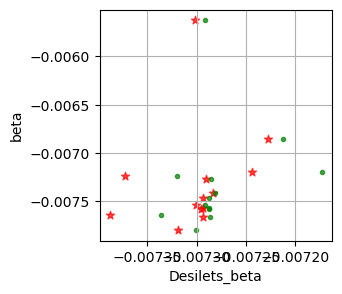

Save file as ./beta_comparison_Desilets_slow.png


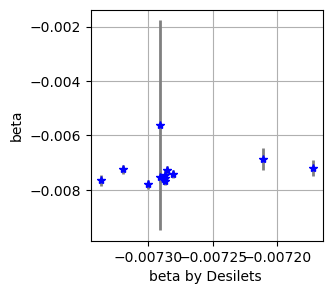

Save file as ./beta_comparison_Desilets_slow.png
Save file as ./beta_comparison_Desiletsb_slow.png


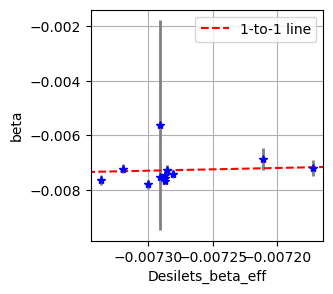

Save file as ./beta_comparison_Desiletsc_slow.png


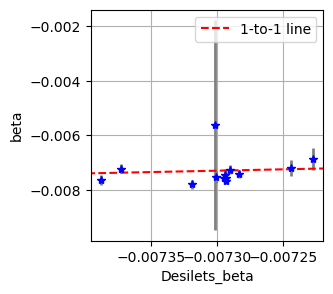

In [16]:
df=dfi.copy()
#df.drop(index=31, inplace=True) #ID: 31 Reading: LEC001

plt.figure(figsize=(3, 3))
plt.scatter(df['Desilets_beta'], df['beta'], color='r', marker='*', alpha=0.7)
plt.scatter(df['Desilets_beta_eff'], df['beta'], color='g', marker='.', alpha=0.7)
plt.xlabel('Desilets_beta')    
plt.ylabel('beta')
plt.grid(True)
plt.show()

pngname="./beta_comparison_Desilets_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')






plt.figure(figsize=(3, 3))

for ii in range(len(df)):
    plt.errorbar(df['Desilets_beta_eff'].iloc[ii], df['beta'].iloc[ii], yerr=df['beta_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)
plt.xlabel('beta by Desilets ')    
plt.ylabel('beta')
plt.grid(True)
plt.show()
pngname="./beta_comparison_Desilets_slow.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')



# Create a new figure
fig, ax = plt.subplots(figsize=(3, 3))
# Plot error bars
for ii in range(len(df)):
    plt.errorbar(df['Desilets_beta_eff'].iloc[ii], df['beta'].iloc[ii], yerr=df['beta_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)
# Set labels
ax.set_xlabel('Desilets_beta_eff')
ax.set_ylabel('beta')

# Get the maximum of the current axes
x_max = ax.get_xlim()[1]
y_max = ax.get_ylim()[1]
max_val = max(x_max, y_max)

# Get the maximum of the current axes
x_min = ax.get_xlim()[0]
y_min = ax.get_ylim()[0]
min_val = max(x_min, y_min)

min_val=np.min(df['beta'])
max_val=np.max(df['beta'])

# Plot the 1:1 line
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1-to-1 line')

# Set the limits to be the same for both axes
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# Set the limits to be the same for both axes
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Add grid and legend
ax.grid(True)
ax.legend()

# Save the figure
pngname = "./beta_comparison_Desiletsb_slow.png"
print("Save file as " + pngname)
fig.savefig(pngname, bbox_inches='tight')

# Show the plot
plt.show()




# Create a new figure
fig, ax = plt.subplots(figsize=(3, 3))
# Plot error bars
for ii in range(len(df)):
    plt.errorbar(df['Desilets_beta'].iloc[ii], df['beta'].iloc[ii], yerr=df['beta_sd'].iloc[ii],
                 fmt='*', capsize=0, color='blue', ecolor='grey', elinewidth=2, capthick=2)
# Set labels
ax.set_xlabel('Desilets_beta')
ax.set_ylabel('beta')

# Get the maximum of the current axes
x_max = ax.get_xlim()[1]
y_max = ax.get_ylim()[1]
max_val = max(x_max, y_max)

# Get the maximum of the current axes
x_min = ax.get_xlim()[0]
y_min = ax.get_ylim()[0]
min_val = max(x_min, y_min)

min_val=np.min(df['beta'])
max_val=np.max(df['beta'])

# Plot the 1:1 line
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1-to-1 line')

# Set the limits to be the same for both axes
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# Set the limits to be the same for both axes
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Add grid and legend
ax.grid(True)
ax.legend()

# Save the figure
pngname = "./beta_comparison_Desiletsc_slow.png"
print("Save file as " + pngname)
fig.savefig(pngname, bbox_inches='tight')

# Show the plot
plt.show()


In [17]:
""""

df=dfi.copy()

csv_filename='my_dataframe_slow.csv'

dfi.to_csv(csv_filename, sep=";",index=True)

# Read the CSV file into a DataFrame
loaded_df = pd.read_csv(csv_filename, sep=';', index_col=0)  # Set index_col to 0 for row names
print("Original DataFrame (df):")
print(df.info())  # Display information about df

print("\nLoaded DataFrame (loaded_df):")
print(loaded_df.info())  # Display information about loaded_df

#excel_filename = 'my_dataframe_slow.xlsx'
#dfi.to_excel(excel_filename, index=True)  # Set index=True to include row names
"""


'"\n\ndf=dfi.copy()\n\ncsv_filename=\'my_dataframe_slow.csv\'\n\ndfi.to_csv(csv_filename, sep=";",index=True)\n\n# Read the CSV file into a DataFrame\nloaded_df = pd.read_csv(csv_filename, sep=\';\', index_col=0)  # Set index_col to 0 for row names\nprint("Original DataFrame (df):")\nprint(df.info())  # Display information about df\n\nprint("\nLoaded DataFrame (loaded_df):")\nprint(loaded_df.info())  # Display information about loaded_df\n\n#excel_filename = \'my_dataframe_slow.xlsx\'\n#dfi.to_excel(excel_filename, index=True)  # Set index=True to include row names\n'